<a href="https://colab.research.google.com/github/EmelyBS/emelybs/blob/main/New_Version_after_Advice_Project_Sentiment_Analysis_27_03_most_accurate!!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#LIBRARIESS

#for basic Data Manipulation:
import pandas as pd #for data manipulation and preprocessing.
import seaborn as sns #for creating statistical plots.
import numpy as np #for numerical computations, array manipulations.
import matplotlib.pyplot as plt #for basic plots.

#for Graphs:
from wordcloud import WordCloud, STOPWORDS #for word cloud graph.
import nltk
from nltk.corpus import stopwords #provides stopwords for text preprocessing.
from collections import Counter #for counting word frequencies.

#for Data Preparation
import spacy #for advanced NLP features (lemmatization and tokenization).
import string #provides string-related constants and operations.
from imblearn.over_sampling import RandomOverSampler #for Oversampling the 3 classes (pos, neg, neut)


#for BERT Transformers
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
#from datasets import Dataset #Facilitates handling and processing of datasets.
from transformers import AutoModel, BertTokenizerFast #Provides a fast tokenizer compatible with BERT models.
from sklearn.model_selection import train_test_split #splits datasets into training and testing subsets.
from sklearn import preprocessing #for OneHotEncode (Data Preparation)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#TensorDataset: Wraps tensors into a dataset.
#DataLoader: Loads data in batches.
#RandomSampler & SequentialSampler: Define strategies for sampling data during training and evaluation.


# for Naive Bayes Model
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report


#for pytorch
import torch # for tensor operations, open-source machine learning library primarily used for developing and training deep learning models.
import torch.nn as nn #provides neural network components.
device = torch.device("cuda") #sets the device to GPU for computation.

# optimizer from hugging face transformers
from torch.optim import AdamW  # ✅ Correct import

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Importing Dataset from Kaggle Notebook Yarin
my_filepath = "/content/drive/MyDrive/Colab Notebooks/Airline_review_edited (1).csv"
my_data = pd.read_csv(my_filepath, index_col ="Row Number")
my_data.head()

,Airline Name,Overall Rating,Review Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
Row Number,,,,,,,,,,,,,,,,,,,
0,AB Aviation,9,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,Moroni to Moheli,11/1/2019,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,AB Aviation,1,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,Moroni to Anjouan,6/1/2019,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,AB Aviation,1,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,6/1/2019,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,Adria Airways,1,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,NaN,Solo Leisure,Economy Class,Frankfurt to Pristina,9/1/2019,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,Adria Airways,1,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,NaN,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,9/1/2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


In [4]:
#DATA CLEANING:
# Step 1: Remove leading and trailing spaces
my_data["Overall Rating"] = my_data["Overall Rating"].str.strip()
print(my_data["Overall Rating"].unique())

# Step 2: Remove non-numeric entries
my_data_cleaned = my_data[my_data["Overall Rating"] != 'n'].copy()
print(my_data_cleaned["Overall Rating"].unique())

# Step 3: Convert the column to numeric (float), invalid values become NaN
my_data_cleaned.loc[:, "Overall Rating"] = pd.to_numeric(my_data_cleaned["Overall Rating"], errors='coerce')
print(my_data_cleaned["Overall Rating"].unique())
# Step 4: Drop rows with NaN (if any invalid entries remain)
my_data_cleaned = my_data_cleaned.dropna(subset=["Overall Rating"])

# Step 5: Force Pandas to recognize the column as numeric
my_data_cleaned["Overall Rating"] = my_data_cleaned["Overall Rating"].astype(float)
print(my_data_cleaned["Overall Rating"].dtype)  # Should now print 'float64'

#View unique values to confirm
print(my_data_cleaned["Overall Rating"].unique())


['9' '1' '8' '2' '3' '5' '6' '7' '4' 'n']
['9' '1' '8' '2' '3' '5' '6' '7' '4']
[9 1 8 2 3 5 6 7 4]
float64
[9. 1. 8. 2. 3. 5. 6. 7. 4.]


In [5]:
#Step 6: Removing all Airlines from which exist less reviews then the average amount
# Group by 'Airline' and count the occurrences
airline_counts = my_data_cleaned.groupby('Airline Name').size()
# Calculate the average count
average_count = airline_counts.mean()

# # Filter airlines that appear more than the average count
valid_airlines = airline_counts[airline_counts > average_count].index
# # Filter the original data to only include valid airlines
filtered_data_1 = my_data_cleaned[my_data_cleaned['Airline Name'].isin(valid_airlines)]

#Removed Airline Names
removed_data = airline_counts[airline_counts < average_count].index

In [6]:
#duplicating dataframe for:
#1: desriptive statistiics
#2: BERT and VADER

filtered_data = filtered_data_1.copy()

In [ ]:
#From here for descriptive statistics and Naive Bayes Model----
#For BERT move down!!!-----------------------
#------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------

In [ ]:
#DATA PREPARATION:
import nltk
import spacy
from nltk.corpus import stopwords

# Download the 'stopwords' resource
nltk.download('stopwords')

#Load spaCy model
nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#INTENSE CLEANING FOR NAVIE BAYES MODEL
#Do not yet!
#Function that runs through all reviews and prepares them for modelling:
def preprocess_text(text):

    text = text.lower().strip() # Convert to lowercase

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize and lemmatize
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text.lower() not in stop_words]
    return ' '.join(tokens)

filtered_data.loc[:, 'Cleaned Review'] = filtered_data['Review'].apply(preprocess_text)

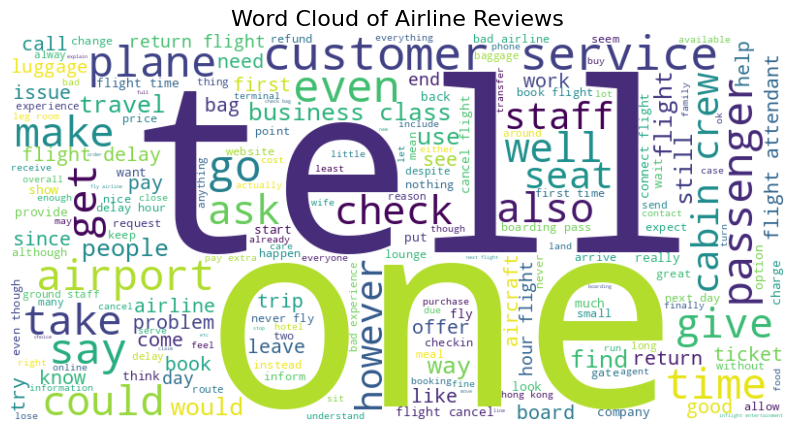

In [ ]:
#VISUAL REPRESENTATION:
#1-Graph showing the most used words in general
# צירוף כל הטקסט בעמודת ה-Review למחרוזת אחת

text = " ".join(str(review) for review in filtered_data['Cleaned Review'].dropna())

# יצירת ענן המילים
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=stop_words,
    colormap="viridis",
    max_words=200
).generate(text)

# הצגת ענן המילים
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Airline Reviews", fontsize=16)
plt.show()

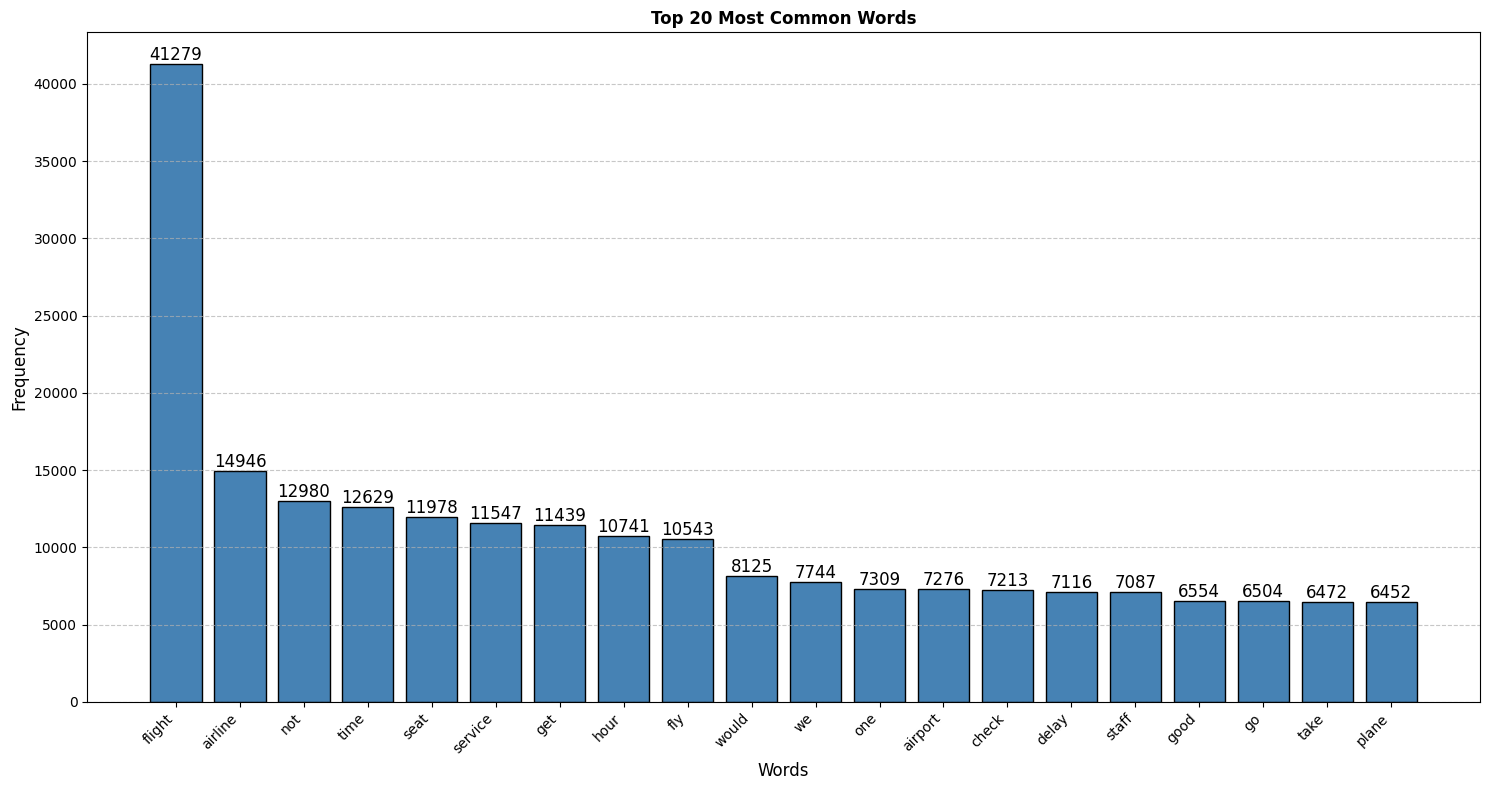

In [ ]:
#Graph showing the Top 20 Most Common Words in the Reviews
all_words = ' '.join(filtered_data['Cleaned Review'].dropna()).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

words = [word[0] for word in common_words]
counts = [word[1] for word in common_words]

plt.figure(figsize=(15, 8))
bars = plt.bar(words, counts, color='steelblue', edgecolor='black')

plt.title('Top 20 Most Common Words', fontsize=12, fontweight='bold')
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
#Run again from here also for BERT and VADER---------------

In [ ]:
#----------------------------------------------------------------------------------------------------

In [7]:
#Cleaning for VADER (use directly)
#and BERT (run another code chunk BERTtokenizerFast to tokenize specific for BERT):
import re

# Unified cleaning function for VADER and BERT
def preprocess_text_unified(text):
    # Remove extra spaces and leading/trailing whitespace
    text = text.strip()
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    # Remove excessive whitespace
    #text = re.sub(r"\s+", " ", text)
    # Retain special characters, punctuation, and numbers (important for BERT)
    return text

# Apply cleaning to the 'Review' column
filtered_data['Cleaned Review'] = filtered_data['Review'].apply(preprocess_text_unified)


In [8]:
#SPLTTING
#REASON: Data Leakage: If you run VADER sentiment analysis before splitting the data, you're applying sentiment analysis to the entire dataset before splitting it into train, validation, and test.
#This means that the sentiment scores you're using might indirectly leak information about your test set into the sentiment classification process.
#This could lead to overly optimistic results when you later evaluate the model on the test set.
#Avoids Test Set Leakage: When you split first, the sentiment analysis of the train, validation, and test sets is done independently, meaning no information from the test set influences the analysis or classification.
from sklearn.model_selection import train_test_split

# First, split into train (70%) and temp (30%) where temp will later be divided into validation and test sets
train_data, temp_data = train_test_split(filtered_data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Check the size of each set to confirm the 70-15-15 split
print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")



Train data size: 13336
Validation data size: 2858
Test data size: 2858


In [9]:
#VADER
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

# Apply VADER sentiment analysis to all datasets (train, validation, and test)
train_data['Sentiment Score'] = train_data['Cleaned Review'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
val_data['Sentiment Score'] = val_data['Cleaned Review'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
test_data['Sentiment Score'] = test_data['Cleaned Review'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

# Classify sentiment into positive or negative only
def classify_sentiment(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'positive'  # on purpose positive to make the bias smaller

# Apply classification to each dataset (train, validation, and test)
train_data['Text Sentiment'] = train_data['Sentiment Score'].apply(classify_sentiment)
val_data['Text Sentiment'] = val_data['Sentiment Score'].apply(classify_sentiment)
test_data['Text Sentiment'] = test_data['Sentiment Score'].apply(classify_sentiment)

print(f"Sentiment distribution in Train data: {train_data['Text Sentiment'].value_counts()}")
print(f"Sentiment distribution in Validation data: {val_data['Text Sentiment'].value_counts()}")
print(f"Sentiment distribution in Test data: {test_data['Text Sentiment'].value_counts()}")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Sentiment distribution in Train data: Text Sentiment
negative    7125
positive    6211
Name: count, dtype: int64
Sentiment distribution in Validation data: Text Sentiment
negative    1507
positive    1351
Name: count, dtype: int64
Sentiment distribution in Test data: Text Sentiment
negative    1526
positive    1332
Name: count, dtype: int64


In [10]:
train_data["Sentiment Score"].head()

# Group by the 'Sentiment' column and count the occurrences
sentiment_counts = train_data.groupby('Text Sentiment').describe()
print(sentiment_counts)

               Overall Rating                                               \
                        count      mean       std  min  25%  50%  75%  max   
Text Sentiment                                                               
negative               7125.0  1.765614  1.470875  1.0  1.0  1.0  2.0  9.0   
positive               6211.0  4.516342  3.293215  1.0  1.0  4.0  8.0  9.0   

               Seat Comfort            ... Value For Money       \
                      count      mean  ...             75%  max   
Text Sentiment                         ...                        
negative             6136.0  1.884289  ...             2.0  5.0   
positive             5475.0  3.435982  ...             5.0  5.0   

               Sentiment Score                                               \
                         count      mean       std     min      25%     50%   
Text Sentiment                                                                
negative                7125.0 -0.72

In [11]:
train_data.tail()

,Airline Name,Overall Rating,Review Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,...,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended,Cleaned Review,Sentiment Score,Text Sentiment
Row Number,,,,,,,,,,,,,,,,,,,,,
13705,Level,1.0,"""showcased a lack of ethics""",5th November 2018,True,I purchased a return ticket Newark to Paris ...,NaN,Solo Leisure,Economy Class,Newark to Paris Orly,...,NaN,NaN,1.0,NaN,NaN,1.0,no,I purchased a return ticket Newark to Paris Or...,0.8670,positive
14558,Malindo Air,1.0,"""lost my baggage""",6th February 2020,True,Perth to Trivandrum via Kuala Lumpur. Worst ...,NaN,Family Leisure,Economy Class,Perth to Trivandrum via Kuala Lumpur,...,1.0,NaN,1.0,1.0,NaN,1.0,no,Perth to Trivandrum via Kuala Lumpur. Worst fl...,-0.8020,negative
6786,Cebu Pacific,1.0,"""This airline is ridiculous""",13th March 2020,True,This airline is ridiculous. This is somethin...,NaN,Business,Economy Class,Manila to Dubai,...,NaN,NaN,1.0,NaN,NaN,1.0,no,This airline is ridiculous. This is something ...,-0.7458,negative
1077,Air Berlin,5.0,"""I wish they had been nicer""",2nd December 2016,False,Bought my ticket one day in advance for $122 f...,A321,Solo Leisure,Economy Class,TXL to DUS,...,2.0,NaN,2.0,NaN,NaN,3.0,no,Bought my ticket one day in advance for $122 f...,0.9077,positive
19346,Sunwing Airlines,1.0,"""Sunwing will not be our carrier""",21st February 2022,False,It seems Sunwing does everything in it's pow...,Boeing 737-800,Couple Leisure,Economy Class,Santa Clara to Ottawa,...,3.0,2.0,3.0,NaN,NaN,2.0,no,It seems Sunwing does everything in it's power...,-0.9042,negative


In [12]:
train_data.describe()

,Overall Rating,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Sentiment Score
count,13336.000000,11611.000000,11549.000000,8925.000000,11386.000000,6794.000000,3839.000000,13208.000000,13336.000000
mean,3.046716,2.615968,2.866655,2.557311,2.326454,2.262143,1.798125,2.425348,-0.035411
std,2.844157,1.453577,1.594355,1.507635,1.589700,1.481727,1.324848,1.584031,0.780051
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-0.998700
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.828350
50%,1.000000,3.000000,3.000000,2.000000,1.000000,2.000000,1.000000,2.000000,-0.218700
75%,5.000000,4.000000,4.000000,4.000000,4.000000,3.000000,2.000000,4.000000,0.855800
max,9.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.999300


In [ ]:
"""for dataset BI"""
# Install openpyxl (if not already installed)
!pip install openpyxl

# Save the DataFrame as an Excel file
filtered_data.to_excel('/content/filtered_airline_reviews.xlsx', index=False)

In [ ]:
from google.colab import files
files.download('/content/filtered_airline_reviews.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

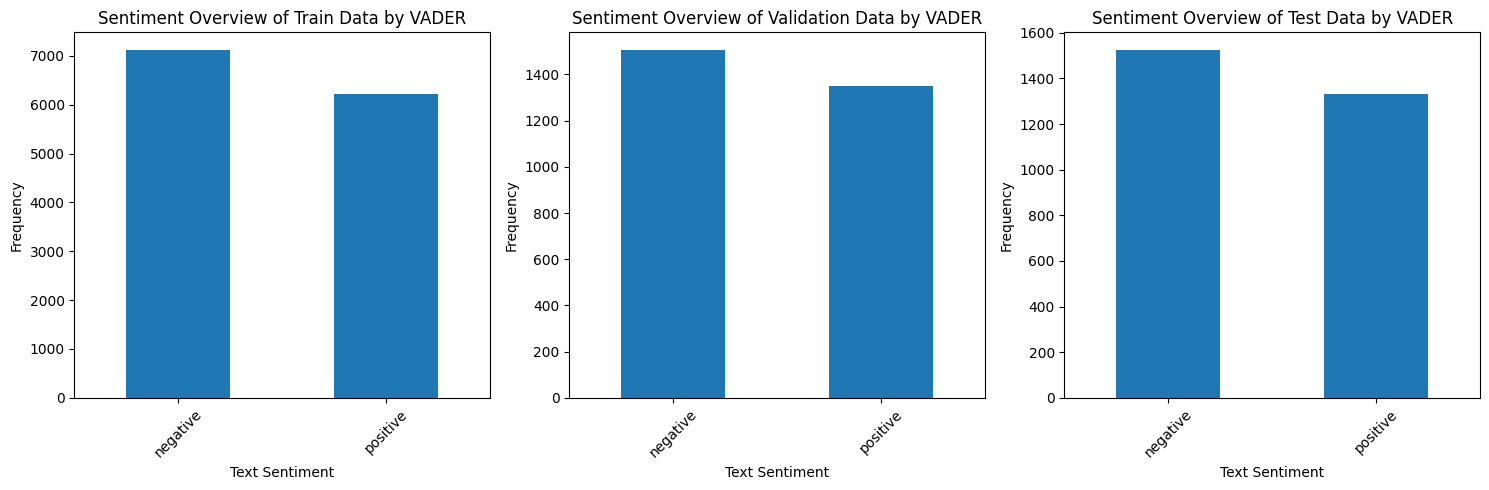

Train Data Sentiment Counts:
Text Sentiment
negative    7125
positive    6211
Name: count, dtype: int64

Validation Data Sentiment Counts:
Text Sentiment
negative    1507
positive    1351
Name: count, dtype: int64

Test Data Sentiment Counts:
Text Sentiment
negative    1526
positive    1332
Name: count, dtype: int64


In [13]:
import matplotlib.pyplot as plt

# Create subplots to display all three bar plots side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot sentiment distribution for Train data
train_data["Text Sentiment"].value_counts().plot.bar(ax=axes[0])
axes[0].set_ylabel("Frequency")
axes[0].set_title("Sentiment Overview of Train Data by VADER")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Plot sentiment distribution for Validation data
val_data["Text Sentiment"].value_counts().plot.bar(ax=axes[1])
axes[1].set_ylabel("Frequency")
axes[1].set_title("Sentiment Overview of Validation Data by VADER")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

# Plot sentiment distribution for Test data
test_data["Text Sentiment"].value_counts().plot.bar(ax=axes[2])
axes[2].set_ylabel("Frequency")
axes[2].set_title("Sentiment Overview of Test Data by VADER")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# Optionally, print the counts for each dataset to confirm
print("Train Data Sentiment Counts:")
print(train_data["Text Sentiment"].value_counts())

print("\nValidation Data Sentiment Counts:")
print(val_data["Text Sentiment"].value_counts())

print("\nTest Data Sentiment Counts:")
print(test_data["Text Sentiment"].value_counts())



In [14]:
# Check for MISSING VALUES in 'Sentiment' and 'Cleaned Review' columns
# Check for missing values in 'Text Sentiment' and 'Cleaned Review' columns for train data
missing_values_train = train_data[['Text Sentiment', 'Cleaned Review']].isnull().sum()
print("Missing values in Train Data:")
print(missing_values_train)

# Check for missing values in 'Text Sentiment' and 'Cleaned Review' columns for validation data
missing_values_val = val_data[['Text Sentiment', 'Cleaned Review']].isnull().sum()
print("\nMissing values in Validation Data:")
print(missing_values_val)

# Check for missing values in 'Text Sentiment' and 'Cleaned Review' columns for test data
missing_values_test = test_data[['Text Sentiment', 'Cleaned Review']].isnull().sum()
print("\nMissing values in Test Data:")
print(missing_values_test)


Missing values in Train Data:
Text Sentiment    0
Cleaned Review    0
dtype: int64

Missing values in Validation Data:
Text Sentiment    0
Cleaned Review    0
dtype: int64

Missing values in Test Data:
Text Sentiment    0
Cleaned Review    0
dtype: int64


In [15]:
# Assuming `Text Sentiment` column contains 'positive' and 'negative'
# Map 'positive' to 1 and 'negative' to 0 in the train dataset
train_data['Label'] = train_data['Text Sentiment'].map({'positive': 1, 'negative': 0})
print("Train Data Label (Last few rows):")
print(train_data["Label"].tail())

# Map 'positive' to 1 and 'negative' to 0 in the validation dataset
val_data['Label'] = val_data['Text Sentiment'].map({'positive': 1, 'negative': 0})
print("\nValidation Data Label (Last few rows):")
print(val_data["Label"].tail())

# Map 'positive' to 1 and 'negative' to 0 in the test dataset
test_data['Label'] = test_data['Text Sentiment'].map({'positive': 1, 'negative': 0})
print("\nTest Data Label (Last few rows):")
print(test_data["Label"].tail())


Train Data Label (Last few rows):
Row Number
13705    1
14558    0
6786     0
1077     1
19346    0
Name: Label, dtype: int64

Validation Data Label (Last few rows):
Row Number
15830    0
19232    0
36       1
17406    1
2522     0
Name: Label, dtype: int64

Test Data Label (Last few rows):
Row Number
9493     1
19201    0
4294     0
10410    1
18796    1
Name: Label, dtype: int64


In [16]:
#checking the proportions of my reviews
# Checking proportions of 'Label' for train, validation, and test data
print("Train Data Proportions:")
print(train_data["Label"].value_counts(normalize=True))

print("\nValidation Data Proportions:")
print(val_data["Label"].value_counts(normalize=True))

print("\nTest Data Proportions:")
print(test_data["Label"].value_counts(normalize=True))


Train Data Proportions:
Label
0    0.534268
1    0.465732
Name: proportion, dtype: float64

Validation Data Proportions:
Label
0    0.527292
1    0.472708
Name: proportion, dtype: float64

Test Data Proportions:
Label
0    0.53394
1    0.46606
Name: proportion, dtype: float64


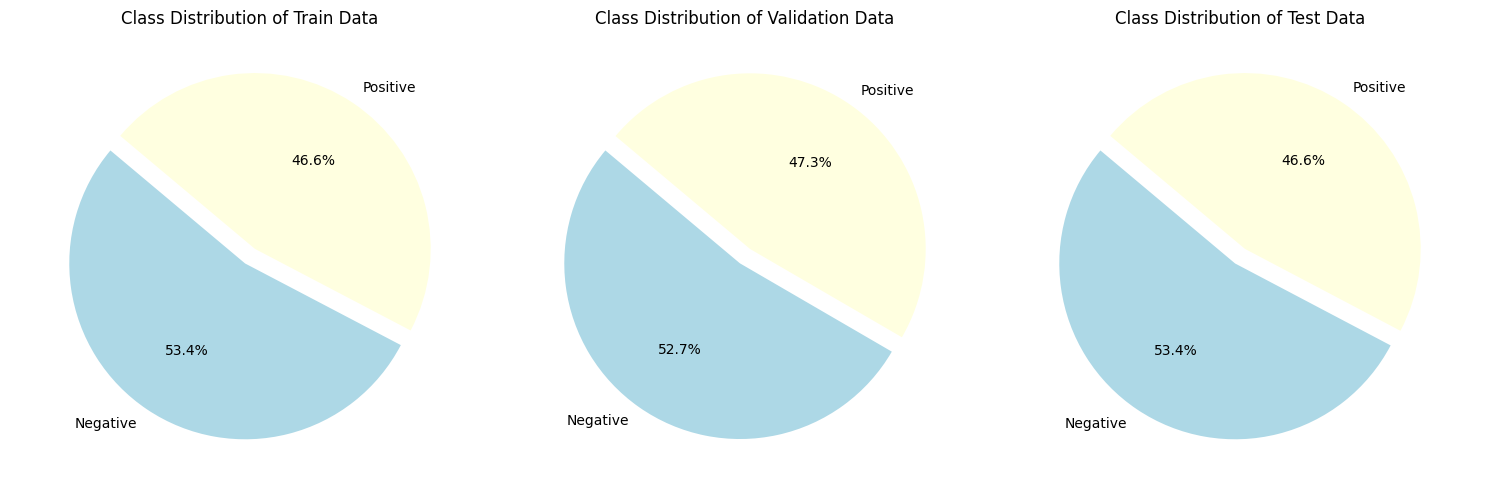

In [17]:
#pie chart of different sentiments in our dataset:
# Plot pie chart for Train Data
import matplotlib.pyplot as plt

# Create subplots to display all three pie charts side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Train Data Pie Chart
train_sizes = train_data["Label"].value_counts(normalize=True)
axes[0].pie(train_sizes, labels=['Negative', 'Positive'], colors=['lightblue', 'lightyellow'],
            explode=(0.05, 0.05), autopct='%1.1f%%', startangle=140)
axes[0].set_title('Class Distribution of Train Data')
axes[0].axis('equal')

# Validation Data Pie Chart
val_sizes = val_data["Label"].value_counts(normalize=True)
axes[1].pie(val_sizes, labels=['Negative', 'Positive'], colors=['lightblue', 'lightyellow'],
            explode=(0.05, 0.05), autopct='%1.1f%%', startangle=140)
axes[1].set_title('Class Distribution of Validation Data')
axes[1].axis('equal')

# Test Data Pie Chart
test_sizes = test_data["Label"].value_counts(normalize=True)
axes[2].pie(test_sizes, labels=['Negative', 'Positive'], colors=['lightblue', 'lightyellow'],
            explode=(0.05, 0.05), autopct='%1.1f%%', startangle=140)
axes[2].set_title('Class Distribution of Test Data')
axes[2].axis('equal')

# Show the plot
plt.tight_layout()
plt.show()

In [18]:
#Duplicating train dataset for BERT and Naice Bayes
# Duplicate the train_data into two separate datasets:
train_data_naive_bayes = train_data.copy()  # For Naive Bayes
train_data_bert = train_data.copy()         # For BERT (no resampling)

In [19]:
#Preparation for Naive Bayes:
from imblearn.over_sampling import RandomOverSampler

# Using RandomOverSampler to balance classes in the train data for Naive Bayes
ros = RandomOverSampler(random_state=2021)
train_resampled_x, train_resampled_y = ros.fit_resample(
    train_data_naive_bayes[['Cleaned Review']],
    train_data_naive_bayes['Label']
)

# Convert the resampled data back to a DataFrame
train_resampled = pd.DataFrame({
    'Cleaned Review': train_resampled_x['Cleaned Review'],
    'Label': train_resampled_y
})

# Verify the class distribution after oversampling for Naive Bayes
print("Naive Bayes resampled class distribution:")
print(train_resampled["Label"].value_counts())

# Verify the shape of the resampled training data for Naive Bayes
print("Train shape for Naive Bayes:", train_resampled.shape)


Naive Bayes resampled class distribution:
Label
1    7125
0    7125
Name: count, dtype: int64
Train shape for Naive Bayes: (14250, 2)


In [20]:
#Naive Bayes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=10000)

# Fit and transform the train data for Naive Bayes and transform the validation and test data
X_train_tfidf = vectorizer.fit_transform(train_resampled["Cleaned Review"])
X_valid_tfidf = vectorizer.transform(val_data["Cleaned Review"])
X_test_tfidf = vectorizer.transform(test_data["Cleaned Review"])

# Initialize Naive Bayes model
nb_model = MultinomialNB()

# Train the Naive Bayes model
nb_model.fit(X_train_tfidf, train_resampled["Label"])

# Make predictions on test data
y_pred = nb_model.predict(X_test_tfidf)

# Evaluate the model
print("Naive Bayes Accuracy:", accuracy_score(test_data['Label'], y_pred))

# Classification Report for Naive Bayes
print("\nClassification Report for Naive Bayes:\n")
print(classification_report(test_data['Label'], y_pred, target_names=["negative", "positive"]))


Naive Bayes Accuracy: 0.7998600419874038

Classification Report for Naive Bayes:

              precision    recall  f1-score   support

    negative       0.79      0.85      0.82      1526
    positive       0.81      0.74      0.78      1332

    accuracy                           0.80      2858
   macro avg       0.80      0.80      0.80      2858
weighted avg       0.80      0.80      0.80      2858



In [21]:
#Checking for OVERFITTING
from sklearn.metrics import accuracy_score, classification_report

# Train Naive Bayes model on the training set
nb_model.fit(X_train_tfidf, train_resampled["Label"])

# Make predictions on both the training and test data
y_train_pred = nb_model.predict(X_train_tfidf)  # Predictions on training data
y_test_pred = nb_model.predict(X_test_tfidf)  # Predictions on test data

# Calculate the accuracy for both the training and test data
train_accuracy = accuracy_score(train_resampled["Label"], y_train_pred)
test_accuracy = accuracy_score(test_data['Label'], y_test_pred)

# Print the accuracy results
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Print classification reports for both training and test predictions
print("\nClassification Report for Training Data:")
print(classification_report(train_resampled["Label"], y_train_pred, target_names=["negative", "positive"]))

print("\nClassification Report for Test Data:")
print(classification_report(test_data['Label'], y_test_pred, target_names=["negative", "positive"]))

# Check for overfitting:
# If training accuracy is much higher than test accuracy, it might indicate overfitting
if train_accuracy > test_accuracy:
    print("\nWarning: The model might be overfitting. Training accuracy is higher than test accuracy.")
else:
    print("\nThe model is generalizing well. No sign of overfitting.")


Training Accuracy: 0.8236491228070175
Test Accuracy: 0.7998600419874038

Classification Report for Training Data:
              precision    recall  f1-score   support

    negative       0.79      0.88      0.83      7125
    positive       0.87      0.77      0.81      7125

    accuracy                           0.82     14250
   macro avg       0.83      0.82      0.82     14250
weighted avg       0.83      0.82      0.82     14250


Classification Report for Test Data:
              precision    recall  f1-score   support

    negative       0.79      0.85      0.82      1526
    positive       0.81      0.74      0.78      1332

    accuracy                           0.80      2858
   macro avg       0.80      0.80      0.80      2858
weighted avg       0.80      0.80      0.80      2858




In [ ]:
#BERT Sentiment Analysis


In [ ]:
#New Version after Adjustments of VADER and order of train, valid test split

In [ ]:
!pip install evaluate

In [24]:
#GOOD
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import get_scheduler, TrainingArguments, Trainer
import evaluate
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from evaluate import load
import numpy as np
import os

#Model will run on GPU and if that is full it will run on CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define a custom dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}
        encoding["labels"] = self.labels[idx]
        return encoding

def load_model(model_name):
    """Load the sentiment analysis model and tokenizer."""
    try:
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2,
                                                                   attention_probs_dropout_prob=0.3,
                                                                   hidden_dropout_prob=0.3,
                                                                   classifier_dropout=0.3).to(device)  # Adding Dropout
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        print(f"Model and tokenizer loaded successfully from {model_name}")
        return model, tokenizer
    except Exception as e:
        print(f"Error loading model: {e}")
        raise

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1).tolist()
    metric = load("accuracy")
    accuracy = metric.compute(predictions=preds, references=labels)

    f1_metric = load("f1")
    f1_macro = f1_metric.compute(predictions=preds, references=labels, average="macro")

    return {
        "accuracy": accuracy["accuracy"],
        "f1_macro": f1_macro["f1"]
    }



Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Model and tokenizer loaded successfully from bert-base-uncased
Starting training...


  0%|          | 0/1668 [00:00<?, ?it/s]

Epoch 1 - Training Accuracy: 0.8512, Validation Accuracy: 0.8968
New best model saved with accuracy: 0.8968
Epoch 2 - Training Accuracy: 0.8977, Validation Accuracy: 0.8947
Training complete.


Final Evaluation Accuracy: 0.8947


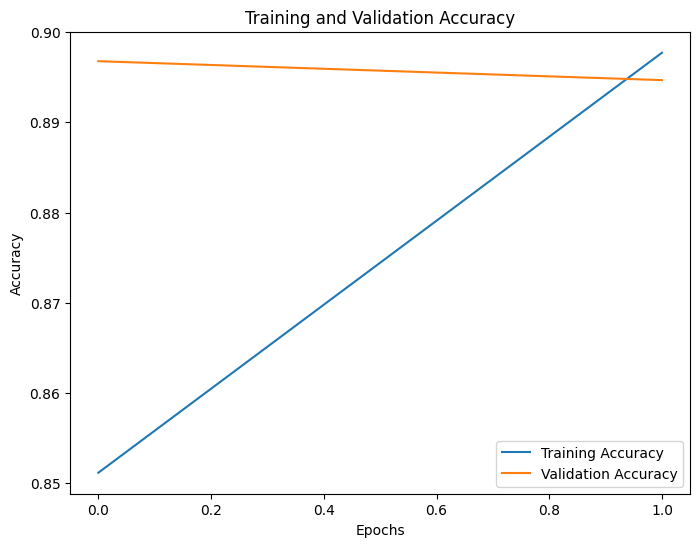

In [25]:
if __name__ == '__main__':
    try:
        # Use train_data_bert for BERT
        train_texts = train_data_bert["Cleaned Review"].tolist()
        train_labels = train_data_bert["Label"].tolist()

        valid_texts = val_data["Cleaned Review"].tolist()  # Assuming valid_data is pre-split
        valid_labels = val_data["Label"].tolist()

        test_texts = test_data["Cleaned Review"].tolist()  # Assuming test_data is pre-split
        test_labels = test_data["Label"].tolist()

        # Load model and tokenizer
        model_name = 'bert-base-uncased'
        model, tokenizer = load_model(model_name)

        # Prepare datasets
        train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
        eval_dataset = SentimentDataset(valid_texts, valid_labels, tokenizer)
        test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

        # Create DataLoaders
        train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
        eval_dataloader = DataLoader(eval_dataset, batch_size=16, shuffle=False)

        # FINE TUNING
        from torch.optim.lr_scheduler import ReduceLROnPlateau

        # Set up optimizer and scheduler
        optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)

        # Set up ReduceLROnPlateau scheduler: Reduce learning rate when validation accuracy plateaus
        scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.1, verbose=True)

        num_epochs = 2
        num_training_steps = num_epochs * len(train_dataloader)

        # Initialize the best validation accuracy tracking
        best_eval_accuracy = 0.0

        model.to(device)

        # Initialize lists to store accuracies for plotting
        train_accuracies = []
        eval_accuracies = []

        # Training loop
        print("Starting training...")
        progress_bar = tqdm(range(num_training_steps))
        model.train()

        for epoch in range(num_epochs):
            # Track train accuracy for this epoch
            correct_preds_train = 0
            total_preds_train = 0

            for batch in train_dataloader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                loss.backward()

                optimizer.step()
                optimizer.zero_grad()
                progress_bar.update(1)

                # Track accuracy during training
                preds = torch.argmax(outputs.logits, dim=-1)
                correct_preds_train += (preds == batch["labels"]).sum().item()
                total_preds_train += preds.size(0)

            # Calculate training accuracy for this epoch
            train_accuracy = correct_preds_train / total_preds_train
            train_accuracies.append(train_accuracy)

            # After each epoch, evaluate on the validation set
            model.eval()
            correct_preds_eval = 0
            total_preds_eval = 0
            all_predictions = []
            all_labels = []

            for batch in eval_dataloader:
                batch = {k: v.to(device) for k, v in batch.items()}
                with torch.no_grad():
                    outputs = model(**batch)

                logits = outputs.logits
                predictions = torch.argmax(logits, dim=-1)

                correct_preds_eval += (predictions == batch["labels"]).sum().item()
                total_preds_eval += predictions.size(0)

                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(batch["labels"].cpu().numpy())

            # Calculate validation accuracy for this epoch
            eval_accuracy = correct_preds_eval / total_preds_eval
            eval_accuracies.append(eval_accuracy)

            print(f"Epoch {epoch + 1} - Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {eval_accuracy:.4f}")

            # Track the best validation accuracy
            if eval_accuracy > best_eval_accuracy:
                best_eval_accuracy = eval_accuracy
                model.save_pretrained("best_fine_tuned_bert")
                tokenizer.save_pretrained("best_fine_tuned_bert")
                print(f"New best model saved with accuracy: {best_eval_accuracy:.4f}")

            # Step the scheduler with the validation accuracy
            scheduler.step(eval_accuracy)  # Use validation accuracy for scheduler step

            model.train()  # Return to training mode after evaluation

        print("Training complete.")

        # Final evaluation on the test set
        metric = evaluate.load("accuracy")
        model.eval()
        all_predictions = []
        all_labels = []

        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

        final_accuracy = metric.compute(predictions=all_predictions, references=all_labels)
        print(f"Final Evaluation Accuracy: {final_accuracy['accuracy']:.4f}")

        # Plotting Training and Validation Accuracy
        plt.figure(figsize=(8, 6))
        plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy')
        plt.plot(range(num_epochs), eval_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {str(e)}")

        model.save_pretrained("fine_tuned_bert")
        tokenizer.save_pretrained("fine_tuned_bert")

        # Evaluation
        model.eval()
        correct_preds_eval = 0
        total_preds_eval = 0
        all_predictions = []
        all_labels = []

        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            correct_preds_eval += (predictions == batch["labels"]).sum().item()
            total_preds_eval += predictions.size(0)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

        # Calculate validation accuracy for this epoch
        eval_accuracy = correct_preds_eval / total_preds_eval
        eval_accuracies.append(eval_accuracy)

        final_accuracy = metric.compute(predictions=all_predictions, references=all_labels)
        print(f"Evaluation Accuracy: {final_accuracy['accuracy']:.4f}")

In [26]:
# Classification Report for Bert Model
print("\nClassification Report for BERT Model:\n")
print(classification_report(all_labels, all_predictions))


Classification Report for BERT Model:

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1507
           1       0.87      0.91      0.89      1351

    accuracy                           0.89      2858
   macro avg       0.89      0.90      0.89      2858
weighted avg       0.90      0.89      0.89      2858



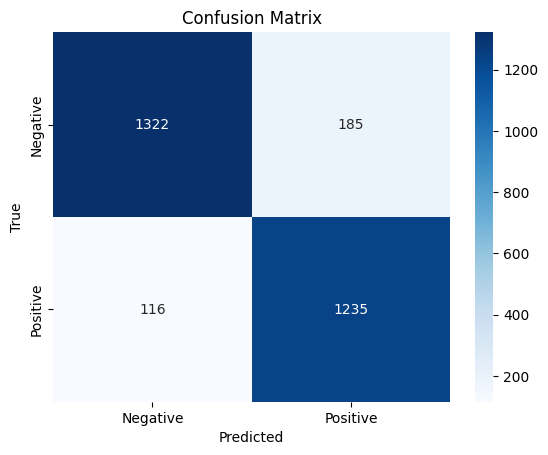

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
#Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [28]:
test_data.head()

,Airline Name,Overall Rating,Review Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,...,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended,Cleaned Review,Sentiment Score,Text Sentiment,Label
Row Number,,,,,,,,,,,,,,,,,,,,,
22456,Volotea,8.0,"""I am very satisfied""",31st December 2022,True,"Flight on time, arrived even with 20 min adv...",A319,Couple Leisure,Economy Class,Nantes to Toulouse,...,3.0,5.0,3.0,3.0,5.0,yes,"Flight on time, arrived even with 20 min advan...",0.6361,positive,1
15489,Oman Air,1.0,"""complete and utter disgrace""",2nd July 2020,True,"Oman Air is, quite simply, a complete and ut...",NaN,Couple Leisure,Economy Class,Amman to Muscat,...,NaN,NaN,NaN,NaN,1.0,no,"Oman Air is, quite simply, a complete and utte...",-0.7160,negative,0
7674,Croatia Airlines,7.0,"""better experience than budget""",12th March 2017,False,London Heathrow to Zagreb. I fly often betwee...,A319,Solo Leisure,Economy Class,London Heathrow to Zagreb,...,4.0,4.0,NaN,NaN,4.0,yes,London Heathrow to Zagreb. I fly often between...,0.9843,positive,1
15356,Olympic Air,9.0,"""better service, lower price""",19th November 2018,True,Direct flight a new service from Athens to Ca...,NaN,Business,Economy Class,Athens to Catania,...,5.0,5.0,3.0,3.0,5.0,yes,Direct flight a new service from Athens to Cat...,0.1779,positive,1
14443,Malaysia Airlines,1.0,"""they served meals free""",20th February 2023,True,I didn't expect that I would get a meal for ...,NaN,Solo Leisure,Economy Class,Bangkok to Incheon via Kuala Lumpur,...,5.0,5.0,5.0,5.0,5.0,yes,I didn't expect that I would get a meal for 2 ...,0.9922,positive,1


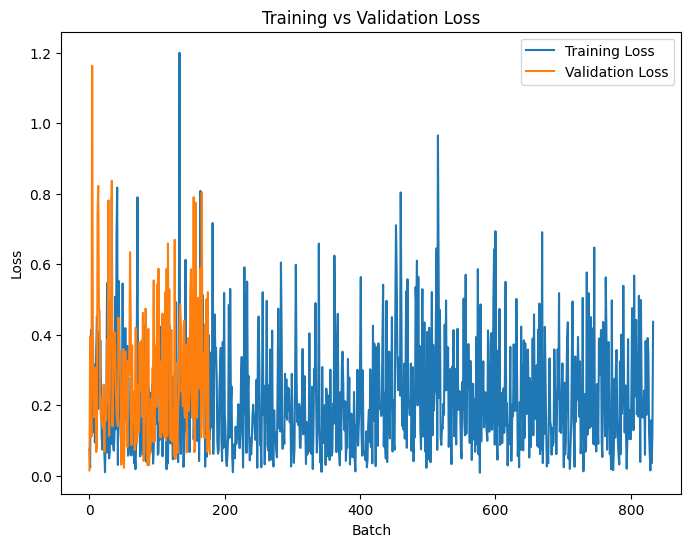

Final Training Loss: 0.2192
Final Validation Loss: 0.2864


In [36]:
#Checking for OVERFITTING with loss function
import torch
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification, BertTokenizer

# Load the saved model and tokenizer
model_name = "best_fine_tuned_bert"  # Path to your saved model
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)
model.to(device)
model.eval()  # Set model to evaluation mode

# Define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Function to compute loss on a dataset
def compute_loss(dataloader):
    total_loss = 0
    total_samples = 0
    all_losses = []

    with torch.no_grad():  # No need for gradient calculation
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            labels = batch["labels"]

            # Compute loss
            loss = loss_fn(logits, labels)
            total_loss += loss.item() * logits.size(0)  # Multiply by batch size
            total_samples += logits.size(0)
            all_losses.append(loss.item())  # Store per-batch loss

    # Compute average loss
    avg_loss = total_loss / total_samples
    return avg_loss, all_losses

# Compute loss for training and validation sets
train_loss, train_losses = compute_loss(train_dataloader)
val_loss, val_losses = compute_loss(eval_dataloader)

# Plot loss curves
plt.figure(figsize=(8, 6))
plt.plot(range(len(train_losses)), train_losses, label="Training Loss")
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Print final average losses
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")


In [35]:
#Saved Model on computer
ls

best_fine_tuned_bert/  drive/  sample_data/


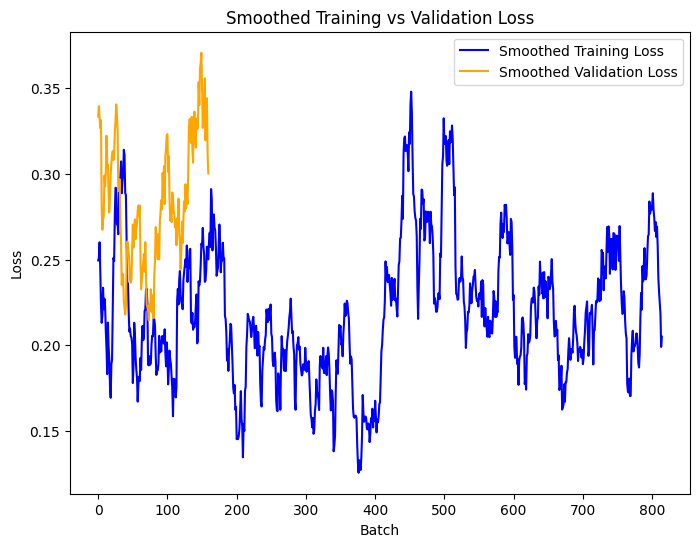

In [37]:
import numpy as np

def moving_average(data, window_size=20):
    """Computes the moving average for smoothing."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply smoothing
window_size = 20  # You can adjust this for more or less smoothing
train_losses_smooth = moving_average(train_losses, window_size)
val_losses_smooth = moving_average(val_losses, window_size)

# Plot smoothed loss curves
plt.figure(figsize=(8, 6))
plt.plot(range(len(train_losses_smooth)), train_losses_smooth, label="Smoothed Training Loss", color='blue')
plt.plot(range(len(val_losses_smooth)), val_losses_smooth, label="Smoothed Validation Loss", color='orange')
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Smoothed Training vs Validation Loss")
plt.legend()
plt.show()

In [39]:
# MODEL EVALUATION
# Load the saved model and tokenizer
model_name = "best_fine_tuned_bert"  # Path to your saved model
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)
model.to(device)
model.eval()
test_texts = test_data["Cleaned Review"].tolist()  # Assuming test_data is pre-split
test_labels = test_data["Label"].tolist()  # Assuming this is your ground truth label

test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

all_predictions = []
all_labels = []

# Iterate over the test data
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    # For binary classification, we apply argmax to get the final class
    predictions = torch.argmax(logits, dim=-1)  # Apply argmax to get the final predicted class

    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(batch["labels"].cpu().numpy())

# Add predictions to the test_data DataFrame
test_data['Predicted Label'] = all_predictions

# Print the first 5 predictions in the requested format
print("First 5 Predictions:")
for i in range(5):
    print(f"Review {i+1}:")
    print(f"Text: {test_data['Cleaned Review'].iloc[i]}")
    print(f"Predicted Sentiment: {test_data['Predicted Label'].iloc[i]}")
    print(f"Actual Sentiment: {test_data['Label'].iloc[i]}")
    print("-" * 80)  # Separator line

# Ensure both lists are binary arrays and calculate accuracy using sklearn's accuracy_score
from sklearn.metrics import accuracy_score

# Convert to numpy arrays to be sure
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

test_accuracy = accuracy_score(all_labels, all_predictions)
print(f"Test Set Accuracy: {test_accuracy:.4f}")


First 5 Predictions:
Review 1:
Text: Flight on time, arrived even with 20 min advance. Everything was well organised, from the luggage deposit to the end of the flight. I am very satisfied.
Predicted Sentiment: 1
Actual Sentiment: 1
--------------------------------------------------------------------------------
Review 2:
Text: Oman Air is, quite simply, a complete and utter disgrace. The airline treats its guests with complete contempt. Flights from Amman to Muscat and back were cancelled due to the COVID-19 pandemic and they are refusing to refund, instead keeping my money (and that of countless other customers) when planes did not even take off. The airline has adopted a policy of hoping customers will stop pestering them so they can keep their money without providing a service. They refuse to help on the phone (or hang up on you) and direct you to an e-mail address. An automatic reply to all e-mails says you may have to wait 15 days for a reply. If you get a reply, they do not help

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
from transformers import BertForSequenceClassification, BertTokenizer

model_name = "best_fine_tuned_bert"  # Path to your saved model
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

model_save_path = "/content/drive/MyDrive/best_fine_tuned_bert"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)


NameError: name 'model' is not defined

In [24]:
import os
# List files in the current working directory
print(os.listdir('/'))

['usr', 'root', 'lib64', 'opt', 'bin', 'srv', 'media', 'sbin', 'tmp', 'home', 'lib', 'var', 'libx32', 'sys', 'dev', 'etc', 'run', 'boot', 'lib32', 'mnt', 'proc', 'kaggle', 'content', '.dockerenv', 'tools', 'datalab', 'python-apt', 'python-apt.tar.xz', 'NGC-DL-CONTAINER-LICENSE', 'cuda-keyring_1.1-1_all.deb']


In [ ]:
#Second Version

In [ ]:
#Third Version

In [ ]:
#Fourth Version

In [ ]:
#WHEN RUNNING FOR BERT:
#run Bert Sentiment Anaylis before this code chunk:
# BERT-specific tokenization (we will tokenize using BERT tokenizer), BERTTokenizerFast handles lowercase!!!!
def preprocess_for_bert(text):
    """
    Prepares text for use with BERT by tokenizing the cleaned text.
    - Tokenizes using BERT tokenizer
    - Pads and truncates sequences to max length
    """
    # Tokenize the text using BERT tokenizer
    #use onlz this line of code and put into training loop
    """Needed"""
    encoding = tokenizer(text, truncation=True, padding='max_length', max_length=512) #changed from 512 to 216 for saving memory to run the model #cahnged back to 512

    return encoding

# Apply the BERT-specific preprocessing (tokenization)
filtered_data['Cleaned Review BERT'] = filtered_data['Cleaned Review'].apply(preprocess_for_bert)


KeyboardInterrupt: 

In [ ]:
#-------------TRAIN TEST SPLIT
"""Needed"""

# Split into train (70%), validation (15%), and test (15%) sets
train_text, temp_text, train_labels, temp_labels = train_test_split(
    filtered_data['Cleaned Review'],
    filtered_data['Label'],
    random_state=2021,
    test_size=0.3,
    stratify=filtered_data['Label']
)

val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text,
    temp_labels,
    random_state=2021,
    test_size=0.5,
    stratify=temp_labels
)

# Combine the training text and labels for oversampling
train_data = pd.DataFrame({'Cleaned Review BERT': train_text, 'Label': train_labels})

In [ ]:
#REALLY no need! after checking
#NO NEED!!!!!!!!!!!!!! recheck with Yarin
#INTENSE CLEANING FOR BERT
#Also not needed !!!! becasue automatically does it, may cause issues when running BERT
# Preprocessing function for BERT
def preprocess_text_for_bert(text):
    """
    Prepares text for use with BERT without over-cleaning.
    """
    # Convert to lowercase and strip whitespace
    text = text.lower().strip()

    # Optional: remove unnecessary whitespace
    text = ' '.join(text.split())

    # Tokenize using BERT tokenizer (handles punctuation and special tokens internally)
    tokens = tokenizer.tokenize(text)

    # Join tokens back to text for compatibility with other parts of the pipeline
    return ' '.join(tokens)

# Apply preprocessing
filtered_data['Cleaned Review BERT'] = filtered_data['Review'].apply(preprocess_text_for_bert)

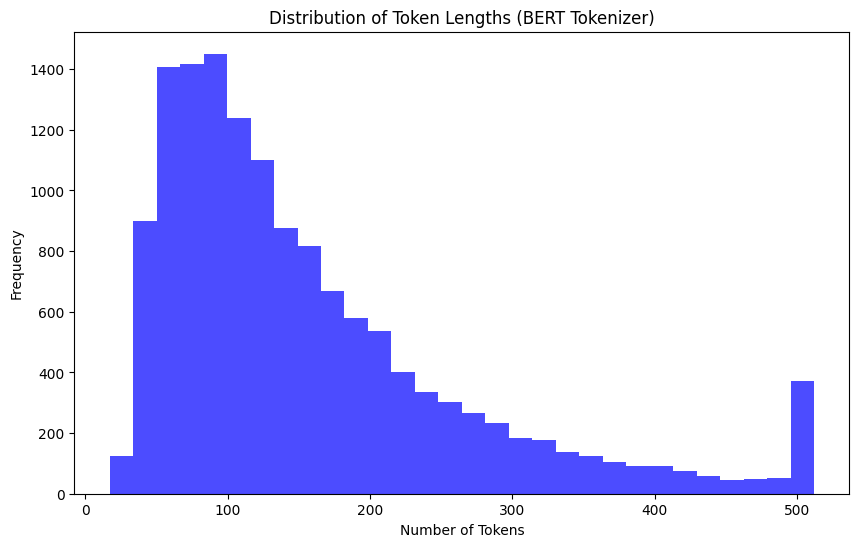

90th Percentile Pad Length: 310


In [ ]:
#REALLY not needed! after checking
#NOT NEEDED WHEN WE DO AUTOMATICALLY PADDING,  recheck with Yarin
#recommended when we use pretrained models !!!!
#Definition of paddding length
train_lens = [len(tokenizer.encode(text, max_length=512, truncation=True)) for text in train_resampled["Cleaned Review"]]
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(train_lens, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Token Lengths (BERT Tokenizer)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

# Determine an appropriate padding length (e.g., 90th percentile of token lengths)
pad_len = int(np.percentile(train_lens, 90))
print(f"90th Percentile Pad Length: {pad_len}")

#train_lens=[len(i.split()) for i in train_text]
#plt.hist(train_lens)

#Choose pad_len to cover most of your data without excessive padding. A common choice is around the 90th percentile of token lengths.
pad_len=145

In [ ]:
#tokenize and encode text data for input into a BERT model

# Necessary imports
import torch
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import AdamW
from torch.nn import CrossEntropyLoss
from torch.nn.functional import softmax
from torch.optim import lr_scheduler


# Extract input_ids and attention_mask from the pre-tokenized data
tokens_train = {'input_ids': train_text.apply(lambda x: x['input_ids']).tolist(),
                'attention_mask': train_text.apply(lambda x: x['attention_mask']).tolist()}
tokens_val = {'input_ids': val_text.apply(lambda x: x['input_ids']).tolist(),
              'attention_mask': val_text.apply(lambda x: x['attention_mask']).tolist()}
tokens_test = {'input_ids': test_text.apply(lambda x: x['input_ids']).tolist(),
              'attention_mask': test_text.apply(lambda x: x['attention_mask']).tolist()}

# # Tokenize and encode sequences with padding and truncation
# tokens_train = tokenizer.batch_encode_plus(
#     train_text.tolist(),
#     max_length=pad_len,
#     pad_to_max_length=True,
#     truncation=True
# )

# tokens_val = tokenizer.batch_encode_plus(
#     val_text.tolist(),
#     max_length=pad_len,
#     pad_to_max_length=True,
#     truncation=True
# )

# tokens_test = tokenizer.batch_encode_plus(
#     test_text.tolist(),
#     max_length=pad_len,
#     pad_to_max_length=True,
#     truncation=True
# )



TypeError: string indices must be integers, not 'str'

In [ ]:
#TILL HERE I GOT
""""
You're on the right track with tokenizing and encoding the sequences for input into BERT.
To continue from here, after tokenizing the text data, you need to:

Convert the tokenized data into PyTorch Tensors.
Prepare DataLoader objects for training, validation, and testing.
Set up the BERT model and the optimizer.
Train the model and evaluate its performance.
"""

# Convert tokenized text data to PyTorch tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

"""Maybe Needed"""
# Convert labels to one-hot encoded format using to_categorical
#train_y = torch.tensor(to_categorical(train_labels, num_classes=3))
#val_y = torch.tensor(to_categorical(val_labels, num_classes=3))
#test_y = torch.tensor(to_categorical(test_labels, num_classes=3))
# Convert labels to integer format (not one-hot encoded)
train_y = torch.tensor(train_labels.values)  # Convert to NumPy array
val_y = torch.tensor(val_labels.values)      # Convert to NumPy array
test_y = torch.tensor(test_labels.values)    # Convert to NumPy array

# Verify shapes
print(f"Train sequences shape: {train_seq.shape}")
print(f"Train labels shape (integer labels): {train_y.shape}")
print(f"Validation sequences shape: {val_seq.shape}")
print(f"Validation labels shape (integer labels): {val_y.shape}")
print(f"Test sequences shape: {test_seq.shape}")
print(f"Test labels shape (integer labels): {test_y.shape}")

"""Needed"""
# Create DataLoaders #Ask Chatgpt about the training Process!!
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=16) #changed from 64 to 32!, #changed it again to 16

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=16)#changed from 64 to 32!, #changed it again to 16


# freeze the BERT architecture
# #Actually not relevant - because simply freezes or unfreezes parameters, but we leave paramters alsways
# for param in model.parameters(): #I CHANGED IT TO TRUE!!!!!!!!!!!!!!!!!!!!!!!!! then fine tuning is actually possilbe, we could also delete that section
#     param.requires_grad = True


#Explanation of output
#Inputs (Tokenized Sequences) → Shape: (num_samples, seq_length)
#num_samples: Number of data points (e.g., 13336 for training).
#seq_length: Fixed length of tokenized sequences (e.g., 216).
#Example: train_seq.shape == [13336, 216].

Train sequences shape: torch.Size([13336, 216])
Train labels shape (integer labels): torch.Size([13336])
Validation sequences shape: torch.Size([2858, 216])
Validation labels shape (integer labels): torch.Size([2858])
Test sequences shape: torch.Size([2858, 216])
Test labels shape (integer labels): torch.Size([2858])


In [ ]:
#no need to build a new net for fine tuning if we already uploaded BERT model from hugging faces
#FINE TUNING THE MODEL:
class BERT_architecture(nn.Module):

    def __init__(self, bert):
        super(BERT_architecture, self).__init__()

        self.bert = bert

        # Freeze the first 8 layers of BERT to prevent overfitting, added this after thrid round of trying to overcome overfitting
        for param in list(self.bert.parameters())[:-2]:
            param.requires_grad = False

        # dropout layer
        self.dropout = nn.Dropout(0.2)#change it from 0.2 to 0.4 and then to 0.5# changed it again to 0.3#changed back to 0.2
        #Dropout helps by randomly setting some of the weights to zero during training, preventing the model from becoming overly reliant on specific features.

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 256) # reducing from 512 to 256
        #768 is the dimensionality of the hidden states for each token, as BERT’s base model produces a 768-dimensional vector for each token.

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512, 2)  # Assuming 2 classes for classification

        #Adding Normalization Layer
        self.layer_norm = nn.LayerNorm(256)

        # # softmax activation function
        # self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
    # Get the BERT output (this includes multiple components)
        outputs = self.bert(sent_id, attention_mask=mask, return_dict=True)  # Ensure it's a dictionary

    # Access the [CLS] token representation (the first token in the sequence)
        cls_hs = outputs.last_hidden_state[:, 0, :]  # (batch_size, 768)

        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.layer_norm(x)
        x = self.dropout(x)

    # Output layer
        x = self.fc2(x)

    # Apply softmax to get probabilities for each class
        #x = self.softmax(x)

        return x



In [ ]:
# FINE TUNING - actaully training the pretrained model
"""Needed"""
#define the optimizer
#first run we did learning curve: 1e-5, now we changed the batch size from 32 to 128 ,so we need to adjust also the learning curve
from transformers import AdamW, get_linear_schedule_with_warmup # Import get_linear_schedule_with_warmup

# Reinitialize optimizer after moving model to the correct device
#optimizer = AdamW(model.parameters(), lr=2e-5)
# Increase weight decay:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.1) #changed fro, 0.05 to 0.1, change from 0.1 to 0.01 and cahnge back to 0.1

# Number of epochs
epochs = 5 #no need for so many epochs if we are only fien tuning, a lot of epochs are needed whne training the model from zero
#possible to out less
# Learning rate scheduler with warmup
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # 10% warmup
    num_training_steps=total_steps
)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
"""Needed"""
from sklearn.utils.class_weight import compute_class_weight

# חישוב המשקלים לקטגוריות, אם נדרש
#negative recieves the least weights, and then positive
# Push weights to the correct device (CUDA or CPU)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class Weights:", class_weights_dict)


Class Weights: {0: np.float64(0.9378340365682137), 1: np.float64(1.0709926116286541)}


In [ ]:
"""Needed"""
# Define the device based on CUDA availability
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the cross-entropy loss function with weights for imbalanced classes
cross_entropy = nn.CrossEntropyLoss(weight=weights)


In [ ]:
"""Needed"""
# Ensure the model's final classification layer is set for 2 classes
model.classifier = torch.nn.Linear(model.config.hidden_size, 2)  # Change to 2 classes

In [ ]:
"""Needed"""
#NEW VERSION TRAINING FUNCTION WITH DIFFERENT LOSS FUNCTION
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
#TRAINING FUNCTION
def train():
    print("\nTraining...")
    model.train()  # Set the model to training mode

    total_loss = 0
    total_preds = []

    gradient_accumulation_steps = 2  # Accumulate gradients over 2 steps


    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print(f'  Batch {step} of {len(train_dataloader)}.')

        # Move all batch tensors to the device (GPU or CPU)
        input_ids, attention_mask, labels = [t.to(device) for t in batch]

        # Forward pass: get model predictions
        model.to(device)
        outputs = model(input_ids, attention_mask)  # Ensure correct output format
        logits = outputs if not isinstance(outputs, dict) else outputs.logits


        # Compute the loss
        loss = cross_entropy(logits, labels)  # Ensure labels are on the correct device

        # Scale the loss for gradient accumulation
        loss = loss / gradient_accumulation_steps

        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Conditional optimizer step and zeroing gradients
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            # Update the learning rate scheduler
            scheduler.step()

        # Append the model predictions
        preds = logits.detach().cpu().numpy()
        total_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds


In [ ]:
"""Needed"""
#NEW VERSION OF EVALUTE FUNCTION
# function for evaluating the model
def evaluate():
    print("\nEvaluating...")
    model.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_preds = []
    num_examples = 0  # Track the total number of examples processed

    with torch.no_grad():  # Disable gradient calculation for evaluation
      for batch in val_dataloader:
          # Move all batch tensors to the device (GPU or CPU)
          input_ids, attention_mask, labels = [t.to(device) for t in batch]

          # Explicitly move model to the correct device to ensure all model components are on the same device
          model.to(device)  # Move the entire model to the device

          # Forward pass: get model predictions
          outputs = model(input_ids, attention_mask)
          logits = outputs if not isinstance(outputs, dict) else outputs.logits

          # Compute the loss
          loss = cross_entropy(logits, labels)  # Ensure labels are on the correct device
          total_loss += loss.item() * len(labels)  # Scale loss by batch size

          num_examples += len(labels) # Update total number of examples

          # Append the model predictions
          preds = logits.detach().cpu().numpy()
          total_preds.append(preds)

      avg_loss = total_loss / num_examples  # Calculate average loss over all examples
      total_preds = np.concatenate(total_preds, axis=0)
      return avg_loss, total_preds

In [ ]:
"""Needed"""
#Training Loop running through the functions
# set initial loss to infinite
# TRAINING LOOP
# Training Loop with improvements
best_valid_loss = float('inf')
train_losses = []
valid_losses = []

# Early stopping parameters
patience = 2
patience_counter = 0
best_model_state = None

# Move model to device once before training
model.to(device) #saving the model to GPU/CPU

for epoch in range(epochs):
    print('\nEpoch {:} / {:}'.format(epoch + 1, epochs))

    # Train the model
    train_loss, _ = train()

    import copy # Import the 'copy' module at the beginning of your script

    # Evaluate the model
    valid_loss, _ = evaluate()

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_model_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
        torch.save(model.state_dict(), 'saved_weights.pt')
    else:
        patience_counter += 1



    # Append training and validation losses
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print('\nTraining Loss: {}'.format(train_loss))
    print('Validation Loss: {}'.format(valid_loss))

        # Check for early stopping
    if patience_counter >= patience:
        print("\nEarly stopping triggered.")
        break
    # Update learning rate scheduler
    scheduler.step()


Epoch 1 / 5

Training...
  Batch 50 of 834.
  Batch 100 of 834.
  Batch 150 of 834.
  Batch 200 of 834.
  Batch 250 of 834.
  Batch 300 of 834.
  Batch 350 of 834.
  Batch 400 of 834.
  Batch 450 of 834.
  Batch 500 of 834.
  Batch 550 of 834.
  Batch 600 of 834.
  Batch 650 of 834.
  Batch 700 of 834.
  Batch 750 of 834.
  Batch 800 of 834.

Evaluating...

Training Loss: 0.13839342003706084
Validation Loss: 0.32482220717374055

Epoch 2 / 5

Training...
  Batch 50 of 834.
  Batch 100 of 834.
  Batch 150 of 834.
  Batch 200 of 834.
  Batch 250 of 834.
  Batch 300 of 834.
  Batch 350 of 834.
  Batch 400 of 834.
  Batch 450 of 834.
  Batch 500 of 834.
  Batch 550 of 834.
  Batch 600 of 834.
  Batch 650 of 834.
  Batch 700 of 834.
  Batch 750 of 834.
  Batch 800 of 834.

Evaluating...

Training Loss: 0.09185033687948733
Validation Loss: 0.3509748745696623

Epoch 3 / 5

Training...
  Batch 50 of 834.
  Batch 100 of 834.
  Batch 150 of 834.
  Batch 200 of 834.
  Batch 250 of 834.
  Batch 30

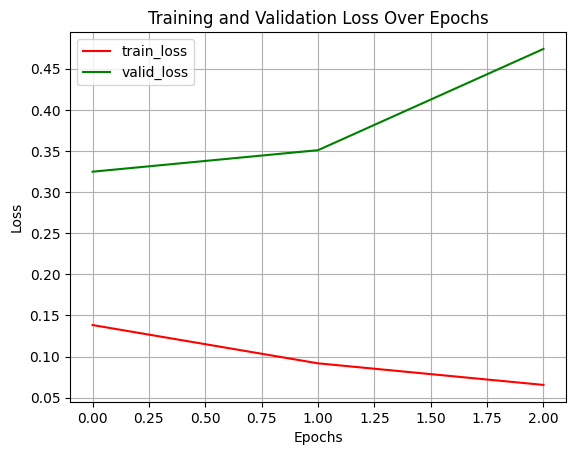

In [ ]:
#TRAINING GRAPH:
from matplotlib import pyplot as plt
plt.plot(train_losses,color = 'red',label = 'train_loss')
plt.plot(valid_losses,color = 'green',label = 'valid_loss')
plt.grid()
plt.legend()
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Loss')    # Label for the y-axis
plt.title('Training and Validation Loss Over Epochs')  # Title for the plot
plt.show()

In [ ]:
import torch
torch.cuda.empty_cache()



NameError: name 'tensor' is not defined

In [ ]:
"""confusion matrix and F1 Score, Precall on the test data"""

#remove the class BERT, which is actuallz a new network we created. a model ,we only need the bert-uncased model -> pretrained from Hugging Faces and fine tuning it
#1. Deep Data Preparation: something somehting and then DataLoaders
#2. Train and Eval here use the tokinze qand simply encode
#3. show results with lss function, F1 score and so on

#use as reference Talias "second Training" part

#no need for input_ids and attentions masks
#we do need the Numpy tensors thing
#tokenizing function can be inside of training loop
